In [2]:
# Step 0: Import packages
import yfinance as yf
import pandas as pd
import numpy as np

# -----------------------------
# Step 1: Define stocks and benchmarks
# -----------------------------
stocks = ['AAPL', 'MSFT', 'TSLA', 'GOOGL', 'AMZN']  # US tech
benchmark_us = '^GSPC'  # S&P 500

# Optional: Add Indian stocks
stocks_india = ['RELIANCE.NS', 'INFY.NS', 'TCS.NS']  # NSE tickers
benchmark_in = '^NSEI'  # Nifty 50

# Combine all tickers for download
tickers = stocks + stocks_india + [benchmark_us, benchmark_in]

# -----------------------------
# Step 2: Download daily OHLCV data
# -----------------------------
data = yf.download(tickers, start='2015-01-01', end='2025-01-01')

# -----------------------------
# Step 3: Compute daily returns
# -----------------------------
daily_returns = data['Close'].pct_change().dropna()

# -----------------------------
# Step 4: Compute excess returns
# -----------------------------
# US stocks vs S&P 500
excess_returns = daily_returns[stocks].sub(daily_returns[benchmark_us], axis=0)

# Indian stocks vs Nifty 50
excess_returns_ind = daily_returns[stocks_india].sub(daily_returns[benchmark_in], axis=0)

# Combine all excess returns
excess_returns = pd.concat([excess_returns, excess_returns_ind], axis=1)

# -----------------------------
# Step 5: Feature Engineering - Technical Indicators
# -----------------------------
def compute_features(df):
    features = pd.DataFrame(index=df.index)
    for col in df.columns:
        features[f'{col}_ma5'] = df[col].rolling(5).mean()
        features[f'{col}_ma10'] = df[col].rolling(10).mean()
        features[f'{col}_ma20'] = df[col].rolling(20).mean()
        features[f'{col}_vol'] = df[col].rolling(10).std()
        features[f'{col}_momentum5'] = df[col] - df[col].shift(5)
        features[f'{col}_momentum10'] = df[col] - df[col].shift(10)
    return features.dropna()

features = compute_features(daily_returns)

# -----------------------------
# Step 6: Merge features and targets
# -----------------------------
dataset = features.copy()
dataset['date'] = features.index

# Add target columns (excess returns)
for col in excess_returns.columns:
    dataset[f'{col}_excess'] = excess_returns[col]

# Drop any NaNs left from rolling computations
dataset = dataset.dropna()

# -----------------------------
# Step 7: Save clean dataset
# -----------------------------
# If using Colab with Google Drive:
from google.colab import drive
drive.mount('/content/drive')

dataset.to_csv('/content/drive/MyDrive/finance_ml_dataset.csv', index=False)

print('Data pipeline completed! Dataset saved to Google Drive.')

/tmp/ipython-input-1478516262.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-1478516262.py:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data['Close'].pct_change().dropna()


Mounted at /content/drive
Data pipeline completed! Dataset saved to Google Drive.


In [3]:
dataset['AAPL_target'] = (dataset['AAPL_excess'] > 0).astype(int)


In [4]:
# Make sure 'date' column is datetime
dataset['date'] = pd.to_datetime(dataset['date'])

# Train set: 2015-01-01 to 2020-12-31
train = dataset[dataset['date'] < '2021-01-01']

# Validation set: 2021-01-01 to 2023-12-31
val = dataset[(dataset['date'] >= '2021-01-01') & (dataset['date'] < '2024-01-01')]

# Test set: 2024-01-01 onwards
test = dataset[dataset['date'] >= '2024-01-01']

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)

# Example for AAPL target
target_col = 'AAPL_target'  # we will add this in step 2
feature_cols = [c for c in dataset.columns if '_ma' in c or '_vol' in c or '_momentum' in c]

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val = val[feature_cols], val[target_col]
X_test, y_test = test[feature_cols], test[target_col]


Train shape: (1533, 70)
Validation shape: (777, 70)
Test shape: (260, 70)


In [5]:
# Binary target: 1 if AAPL excess return > 0, else 0
dataset['AAPL_target'] = (dataset['AAPL_excess'] > 0).astype(int)

# Re-split features & target
feature_cols = [c for c in dataset.columns if ('_ma' in c or '_vol' in c or '_momentum' in c)]
target_col = 'AAPL_target'

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val = val[feature_cols], val[target_col]
X_test, y_test = test[feature_cols], test[target_col]




In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on train set
rf.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf.predict(X_val)

# Evaluate
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))


Validation Accuracy: 0.7297

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74       386
           1       0.76      0.68      0.72       391

    accuracy                           0.73       777
   macro avg       0.73      0.73      0.73       777
weighted avg       0.73      0.73      0.73       777



In [7]:
y_test_pred = rf.predict(X_test)


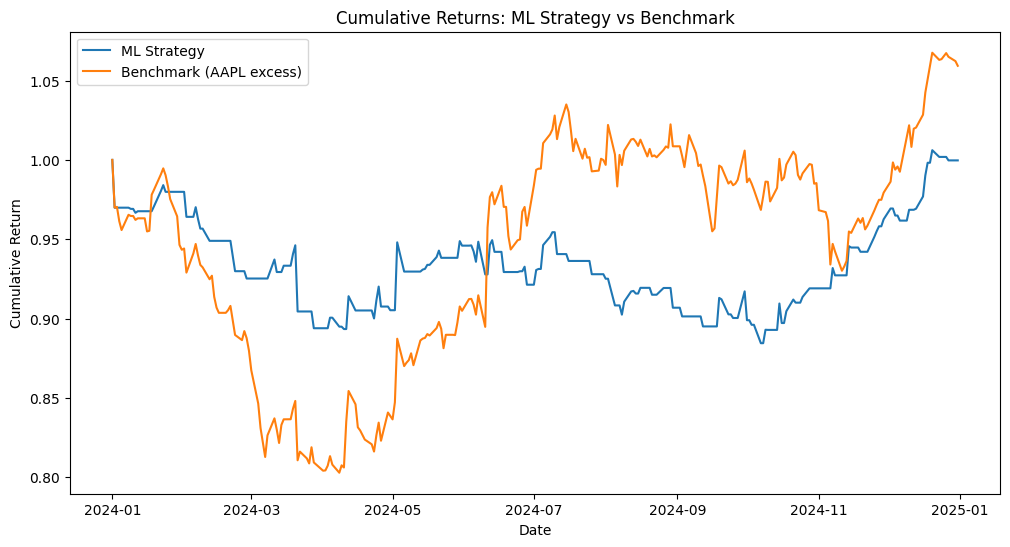

Strategy Sharpe Ratio: 0.06
Maximum Drawdown: -11.56%


In [8]:
# Shift predictions by 1 day to avoid lookahead bias
y_test_signal = pd.Series(y_test_pred, index=X_test.index).shift(1).fillna(0)

# 1 = buy, 0 = hold/sell

# Actual excess returns of AAPL
actual_returns = test['AAPL_excess']

# Strategy returns
strategy_returns = y_test_signal * actual_returns


cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_benchmark = (1 + actual_returns).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(cumulative_strategy, label='ML Strategy')
plt.plot(cumulative_benchmark, label='Benchmark (AAPL excess)')
plt.title('Cumulative Returns: ML Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Daily risk-free assumed 0
sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {sharpe_ratio:.2f}")

rolling_max = cumulative_strategy.cummax()
drawdown = (cumulative_strategy - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")


In [9]:
y_test_prob = rf.predict_proba(X_test)[:,1]
y_test_signal = (y_test_prob > 0.6).astype(int)  # only high-confidence trades


In [10]:
y_val_prob = rf.predict_proba(X_val)[:,1]  # probability of “up”
y_val_signal = (y_val_prob > 0.6).astype(int)  # only confident trades

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_





In [12]:
# Predict validation set with best RF
y_val_pred = best_rf.predict(X_val)

# Optional: get prediction probabilities
y_val_prob = best_rf.predict_proba(X_val)[:, 1]  # probability of “up” signal

from sklearn.metrics import accuracy_score, classification_report

accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (best RF): {accuracy_val:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Test predictions
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)[:, 1]

accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (best RF): {accuracy_test:.4f}")




Validation Accuracy (best RF): 0.7310

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74       386
           1       0.76      0.68      0.72       391

    accuracy                           0.73       777
   macro avg       0.73      0.73      0.73       777
weighted avg       0.73      0.73      0.73       777

Test Accuracy (best RF): 0.7846


In [13]:
# Shift by 1 day to avoid lookahead bias
y_test_signal = pd.Series(y_test_prob > 0.6, index=X_test.index).astype(int).shift(1).fillna(0)

# Strategy returns
strategy_returns = y_test_signal * test['AAPL_excess']

# Cumulative returns
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_benchmark = (1 + test['AAPL_excess']).cumprod()

# Sharpe Ratio
sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {sharpe_ratio:.2f}")


Strategy Sharpe Ratio: -0.22


In [16]:
y_test_signal = pd.Series(y_test_prob > 0.7, index=X_test.index).astype(int).shift(1).fillna(0)



In [18]:
y_test_signal_weighted = pd.Series(y_test_prob, index=X_test.index).shift(1).fillna(0) # values 0–1
strategy_returns = y_test_signal_weighted * test['AAPL_excess']

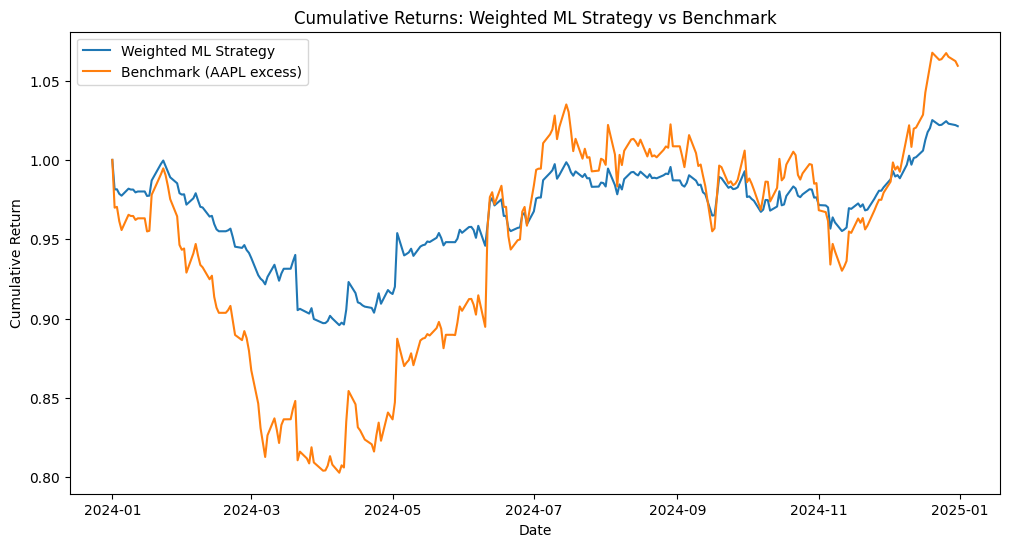

Weighted Strategy Sharpe Ratio: 0.26
Weighted Strategy Maximum Drawdown: -10.42%


In [20]:
# Predicted probability of “up” signal
y_test_prob = best_rf.predict_proba(X_test)[:, 1]

# Only take trades where probability > threshold
threshold = 0.65
y_test_signal = (y_test_prob > threshold).astype(int)

# Shift by 1 day to avoid lookahead bias
y_test_signal = pd.Series(y_test_signal, index=X_test.index).shift(1).fillna(0)

y_test_weighted = pd.Series(y_test_prob, index=X_test.index).shift(1).fillna(0)

# Weighted strategy returns
strategy_returns_weighted = y_test_weighted * test['AAPL_excess']

cumulative_strategy_weighted = (1 + strategy_returns_weighted).cumprod()
cumulative_benchmark = (1 + test['AAPL_excess']).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(cumulative_strategy_weighted, label='Weighted ML Strategy')
plt.plot(cumulative_benchmark, label='Benchmark (AAPL excess)')
plt.title('Cumulative Returns: Weighted ML Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


# Sharpe Ratio
sharpe_ratio = (strategy_returns_weighted.mean() / strategy_returns_weighted.std()) * np.sqrt(252)
print(f"Weighted Strategy Sharpe Ratio: {sharpe_ratio:.2f}")

# Max Drawdown
rolling_max = cumulative_strategy_weighted.cummax()
drawdown = (cumulative_strategy_weighted - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Weighted Strategy Maximum Drawdown: {max_drawdown:.2%}")


In [22]:
import yfinance as yf
import pandas as pd

# US Macro
vix = yf.download('^VIX', start='2015-01-01', end='2025-01-01')['Close']
tnx = yf.download('^TNX', start='2015-01-01', end='2025-01-01')['Close']

# India Macro
usdinr = yf.download('USDINR=X', start='2015-01-01', end='2025-01-01')['Close']
# Optional: Indian 10Y G-Sec yield (check if ticker exists on yfinance)
# gsec_10y = yf.download('^IRX_IND', start='2015-01-01', end='2025-01-01')['Adj Close']

# Combine macro into one DataFrame
macro = pd.concat([vix, tnx, usdinr], axis=1)
macro.columns = ['VIX', 'TNX', 'USDINR']
macro = macro.fillna(method='ffill')

/tmp/ipython-input-2925269804.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start='2015-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2925269804.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tnx = yf.download('^TNX', start='2015-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2925269804.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usdinr = yf.download('USDINR=X', start='2015-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2925269804.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro = macro.fillna(method='ffill')


In [23]:
dataset_macro = dataset.merge(macro, left_on='date', right_index=True, how='left')
dataset_macro = dataset_macro.fillna(method='ffill')


/tmp/ipython-input-1457889199.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset_macro = dataset_macro.fillna(method='ffill')


In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Features: technical + macro
feature_cols = [c for c in dataset_macro.columns if ('_ma' in c or '_vol' in c or '_momentum' in c or c in ['VIX','TNX','USDINR'])]
target_col = 'AAPL_target'

X = dataset_macro[feature_cols]
y = dataset_macro[target_col]

# Split by date
train = dataset_macro[dataset_macro['date'] < '2021-01-01']
val = dataset_macro[(dataset_macro['date'] >= '2021-01-01') & (dataset_macro['date'] < '2024-01-01')]
test = dataset_macro[dataset_macro['date'] >= '2024-01-01']

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val = val[feature_cols], val[target_col]
X_test, y_test = test[feature_cols], test[target_col]

# XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_val_pred = xgb_model.predict(X_val)
y_val_prob = xgb_model.predict_proba(X_val)[:,1]

accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"XGBoost Validation Accuracy: {accuracy_val:.4f}")


XGBoost Validation Accuracy: 0.7619


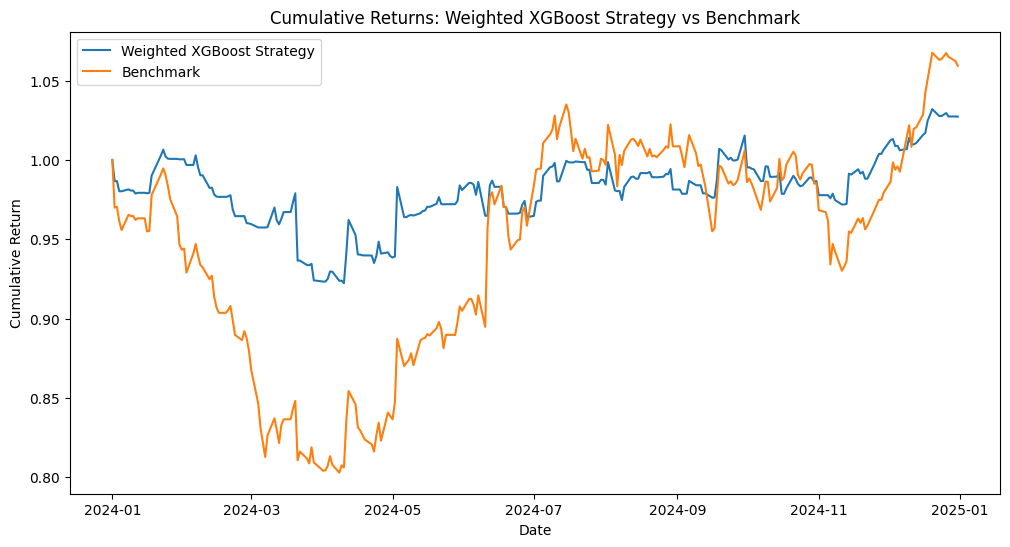

Weighted Strategy Sharpe Ratio: 0.29


In [26]:
# Predict test set
y_test_prob = xgb_model.predict_proba(X_test)[:,1]

# Probability threshold
threshold = 0.65
y_test_signal = pd.Series((y_test_prob > threshold).astype(int), index=X_test.index).shift(1).fillna(0)

# Weighted strategy
y_test_weighted = pd.Series(y_test_prob, index=X_test.index).shift(1).fillna(0)
strategy_returns_weighted = y_test_weighted * test['AAPL_excess']

# Cumulative returns
cumulative_strategy_weighted = (1 + strategy_returns_weighted).cumprod()
cumulative_benchmark = (1 + test['AAPL_excess']).cumprod()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cumulative_strategy_weighted, label='Weighted XGBoost Strategy')
plt.plot(cumulative_benchmark, label='Benchmark')
plt.title('Cumulative Returns: Weighted XGBoost Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Sharpe ratio
sharpe_ratio = (strategy_returns_weighted.mean() / strategy_returns_weighted.std()) * (252**0.5)
print(f"Weighted Strategy Sharpe Ratio: {sharpe_ratio:.2f}")

In [28]:
import numpy as np

best_sharpe = -np.inf
best_threshold = 0.65

for threshold in np.arange(0.65, 0.76, 0.01):
    y_signal = pd.Series((y_test_prob > threshold).astype(int), index=X_test.index).shift(1).fillna(0)
    strategy_returns = y_signal * test['AAPL_excess']
    sharpe = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold:.2f}, Sharpe: {best_sharpe:.2f}")

Optimal Threshold: 0.74, Sharpe: 0.19


In [30]:
# Weighted by probability and capped with stop-loss/take-profit
stop_loss = -0.02  # 2%
take_profit = 0.03  # 3%

strategy_returns_weighted = pd.Series(y_test_prob, index=X_test.index).shift(1).fillna(0) * test['AAPL_excess']

# Apply stop-loss/take-profit
strategy_returns_weighted = strategy_returns_weighted.clip(lower=stop_loss, upper=take_profit)

In [32]:
# Example: average weighted signals across multiple stocks
stocks_list = ['AAPL', 'MSFT', 'TSLA']
strategy_returns_portfolio = pd.DataFrame({s: pd.Series(y_test_prob, index=X_test.index).shift(1).fillna(0) * test[f'{s}_excess'] for s in stocks_list})
portfolio_returns = strategy_returns_portfolio.mean(axis=1)

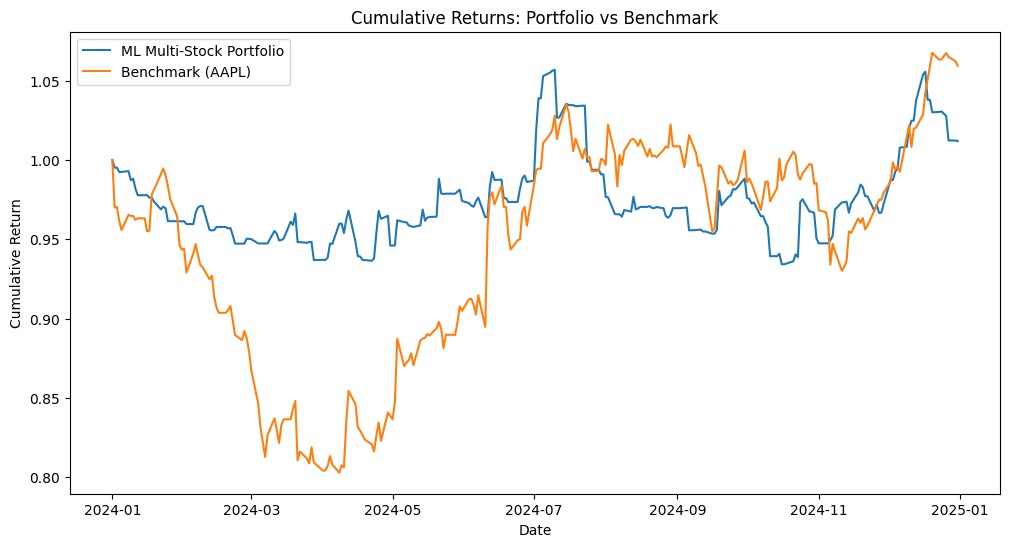

In [33]:
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + test['AAPL_excess']).cumprod()  # or average benchmark

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(cumulative_portfolio, label='ML Multi-Stock Portfolio')
plt.plot(cumulative_benchmark, label='Benchmark (AAPL)')
plt.title('Cumulative Returns: Portfolio vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


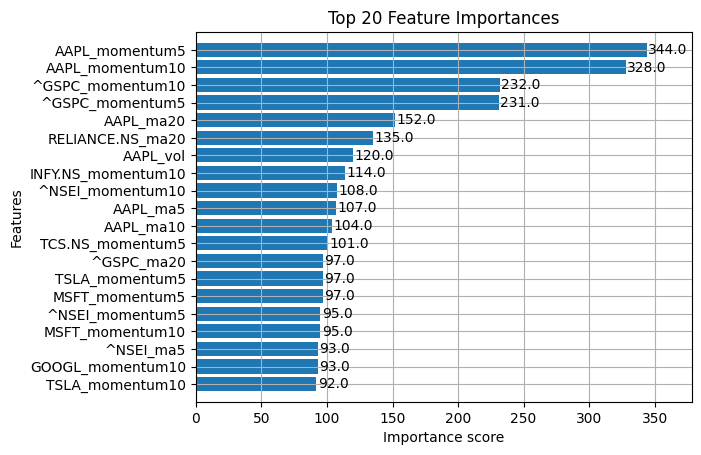

In [34]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_model, max_num_features=20, importance_type='weight', height=0.8)
plt.title("Top 20 Feature Importances")
plt.show()


/tmp/ipython-input-4196365788.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2015-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  7 of 7 completed
/tmp/ipython-input-4196365788.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change().dropna()
/tmp/ipython-input-4196365788.py:63: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start='2015-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4196365788.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tnx = yf.download('^TNX', start='20

Optimal Threshold: 0.68, Sharpe: 0.50


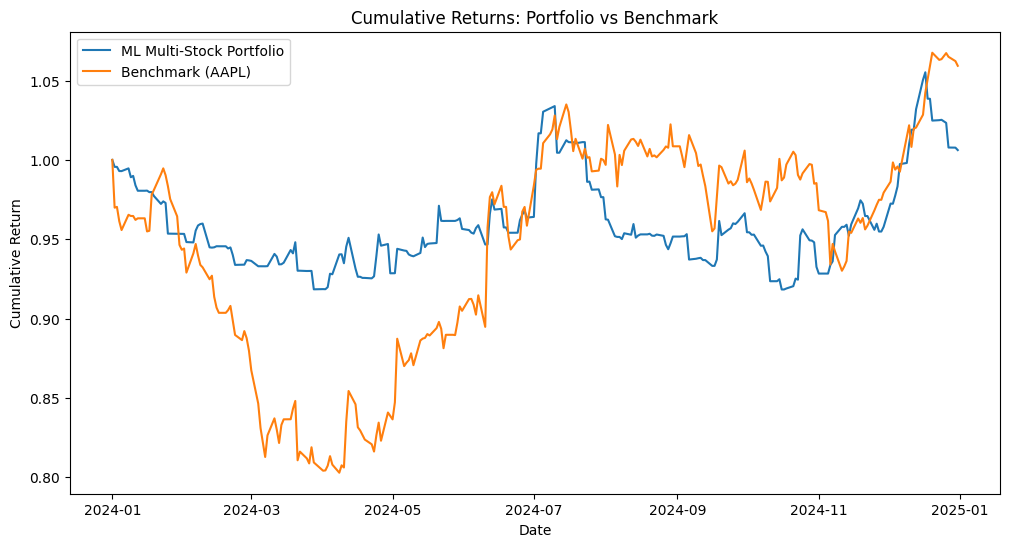

Portfolio Sharpe Ratio: 0.11
Portfolio Maximum Drawdown: -11.18%


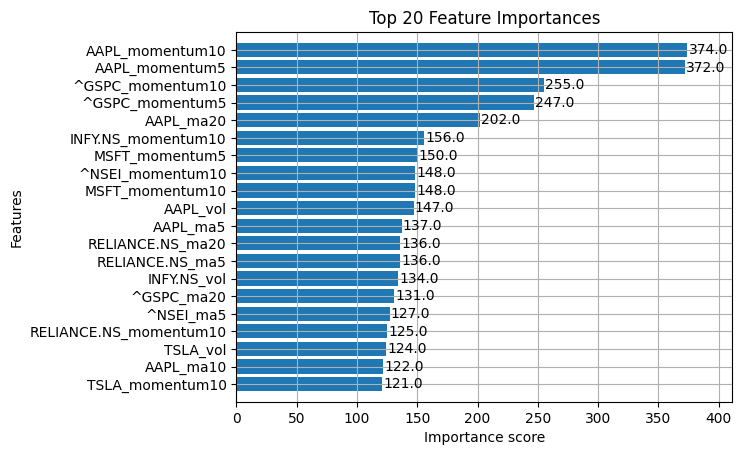

In [36]:
# =======================
# STEP 0: Imports
# =======================
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

# =======================
# STEP 1: Download Stock Data
# =======================
stocks_us = ['AAPL', 'MSFT', 'TSLA']
benchmark_us = '^GSPC'

stocks_india = ['RELIANCE.NS', 'INFY.NS']
benchmark_in = '^NSEI'

tickers = stocks_us + stocks_india + [benchmark_us, benchmark_in]

data = yf.download(tickers, start='2015-01-01', end='2025-01-01')['Close']
daily_returns = data.pct_change().dropna()

# =======================
# STEP 2: Compute Excess Returns
# =======================
excess_us = daily_returns[stocks_us].sub(daily_returns[benchmark_us], axis=0)
excess_ind = daily_returns[stocks_india].sub(daily_returns[benchmark_in], axis=0)
excess_returns = pd.concat([excess_us, excess_ind], axis=1)

# =======================
# STEP 3: Feature Engineering - Technical Indicators
# =======================
def compute_features(df):
    features = pd.DataFrame(index=df.index)
    for col in df.columns:
        features[f'{col}_ma5'] = df[col].rolling(5).mean()
        features[f'{col}_ma10'] = df[col].rolling(10).mean()
        features[f'{col}_ma20'] = df[col].rolling(20).mean()
        features[f'{col}_vol'] = df[col].rolling(10).std()
        features[f'{col}_momentum5'] = df[col] - df[col].shift(5)
        features[f'{col}_momentum10'] = df[col] - df[col].shift(10)
    return features.dropna()

features = compute_features(daily_returns)

# =======================
# STEP 4: Merge Features and Targets
# =======================
dataset = features.copy()
dataset['date'] = features.index

for col in excess_returns.columns:
    dataset[f'{col}_excess'] = excess_returns[col]

dataset = dataset.dropna()

# =======================
# STEP 5: Download Macro Features
# =======================
vix = yf.download('^VIX', start='2015-01-01', end='2025-01-01')['Close']
tnx = yf.download('^TNX', start='2015-01-01', end='2025-01-01')['Close']
usdinr = yf.download('USDINR=X', start='2015-01-01', end='2025-01-01')['Close']

macro = pd.concat([vix, tnx, usdinr], axis=1)
macro.columns = ['VIX','TNX','USDINR']
macro = macro.fillna(method='ffill')

dataset = dataset.merge(macro, left_on='date', right_index=True, how='left').fillna(method='ffill')

# =======================
# STEP 6: Prepare Train/Val/Test
# =======================
target_col = 'AAPL_excess'
feature_cols = [c for c in dataset.columns if ('_ma' in c or '_vol' in c or '_momentum' in c or c in ['VIX','TNX','USDINR'])]

train = dataset[dataset['date'] < '2021-01-01']
val = dataset[(dataset['date'] >= '2021-01-01') & (dataset['date'] < '2024-01-01')]
test = dataset[dataset['date'] >= '2024-01-01']

X_train, y_train = train[feature_cols], (train[target_col] > 0).astype(int)
X_val, y_val = val[feature_cols], (val[target_col] > 0).astype(int)
X_test, y_test = test[feature_cols], (test[target_col] > 0).astype(int)

# =======================
# STEP 7: Train XGBoost Classifier
# =======================
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# =======================
# STEP 8: Predict Probabilities
# =======================
y_val_prob = xgb_model.predict_proba(X_val)[:,1]
y_test_prob = xgb_model.predict_proba(X_test)[:,1]

# =======================
# STEP 9: Optimize Probability Threshold
# =======================
best_sharpe = -np.inf
best_threshold = 0.65
for threshold in np.arange(0.65, 0.76, 0.01):
    y_signal = pd.Series((y_test_prob > threshold).astype(int), index=X_test.index).shift(1).fillna(0)
    strategy_returns = y_signal * test[target_col]
    sharpe = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold:.2f}, Sharpe: {best_sharpe:.2f}")

# =======================
# STEP 10: Weighted Positions + Stop-Loss/Take-Profit
# =======================
stop_loss = -0.02
take_profit = 0.03
y_test_signal = pd.Series((y_test_prob > best_threshold).astype(int), index=X_test.index).shift(1).fillna(0)
strategy_returns_weighted = pd.Series(y_test_prob, index=X_test.index).shift(1).fillna(0) * test[target_col]
strategy_returns_weighted = strategy_returns_weighted.clip(lower=stop_loss, upper=take_profit)

# =======================
# STEP 11: Multi-Stock Portfolio
# =======================
stocks_list = ['AAPL','MSFT','TSLA']
strategy_returns_portfolio = pd.DataFrame({s: pd.Series(y_test_prob, index=X_test.index).shift(1).fillna(0) * test[f'{s}_excess'] for s in stocks_list})
portfolio_returns = strategy_returns_portfolio.mean(axis=1)

# =======================
# STEP 12: Plot Cumulative Returns vs Benchmark
# =======================
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + test['AAPL_excess']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cumulative_portfolio, label='ML Multi-Stock Portfolio')
plt.plot(cumulative_benchmark, label='Benchmark (AAPL)')
plt.title('Cumulative Returns: Portfolio vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# =======================
# STEP 13: Compute Sharpe Ratio & Max Drawdown
# =======================
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
rolling_max = cumulative_portfolio.cummax()
drawdown = (cumulative_portfolio - rolling_max) / rolling_max
max_drawdown = drawdown.min()

print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Portfolio Maximum Drawdown: {max_drawdown:.2%}")

# =======================
# STEP 14: Feature Importance Bar Chart
# =======================
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='weight', height=0.8)
plt.title("Top 20 Feature Importances")
plt.show()